In [96]:
import atlite
import xarray as xr
import pandas as pd
import scipy.sparse as sp
import numpy as np

import pgeocode
from collections import OrderedDict

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

sns.set_style("whitegrid")



In [97]:
import requests
import os
import zipfile


def download_file(url, local_filename):
    # variant of http://stackoverflow.com/a/16696317
    if not os.path.exists(local_filename):
        r = requests.get(url, stream=True)
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
    return local_filename

In [98]:
opsd_fn = download_file(
    "https://data.open-power-system-data.org/index.php?package=time_series&version=2020-10-06&action=customDownload&resource=3&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bfrom%5D=2019-01-01&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bto%5D=2020-05-01&filter%5BRegion%5D%5B%5D=DE&filter%5BVariable%5D%5B%5D=solar_generation_actual&filter%5BVariable%5D%5B%5D=wind_generation_actual&downloadCSV=Download+CSV",
    "time_series_60min_singleindex_filtered.csv",
)

In [99]:
opsd = pd.read_csv(opsd_fn, parse_dates=True, index_col=0)

# we later use the (in current version) timezone unaware datetime64
# to work together with this format, we have to remove the timezone
# timezone information. We are working with UTC everywhere.

opsd.index = opsd.index.tz_convert(None)

# We are only interested in the 2012 data
opsd = opsd[("2018" < opsd.index) & (opsd.index < "2020")]

In [100]:
eeg_fn = download_file(
    "http://www.energymap.info/download/eeg_anlagenregister_2015.08.utf8.csv.zip",
    "eeg_anlagenregister_2015.08.utf8.csv.zip",
)

with zipfile.ZipFile(eeg_fn, "r") as zip_ref:
    zip_ref.extract("eeg_anlagenregister_2015.08.utf8.csv")

In [101]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd

shp = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )
)
de_record = list(filter(lambda c: c.attributes["ISO_A2"] == "DE", shp.records()))[0]
de = pd.Series({**de_record.attributes, "geometry": de_record.geometry})
x1, y1, x2, y2 = de["geometry"].bounds

In [102]:
cutout = atlite.Cutout(
    path="Germany-2019.nc",
    module="era5",
    x=slice(4.8479, 15.8638),
    y=slice(55.2353, 46.9644),
    time=slice("2019-01", "2019-12")
)

module = "era5"
slice("2019-01", "2019-12")
x = slice(4.8479, 15.8638) # Longitude
y = slice(55.2353, 46.9644)

/Users/tomkaehler/Documents/Uni/BA/venv/lib/python3.11/site-packages/atlite/cutout.py:190: UserWarning: Arguments module, x, y, time are ignored, since cutout is already built.
  warn(


In [103]:
cutout.prepare()

<Cutout "Germany-2019">
 x = 5.00 ⟷ 15.75, dx = 0.25
 y = 47.00 ⟷ 55.00, dy = 0.25
 time = 2019-01-01 ⟷ 2019-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [104]:
def load_capacities(typ, cap_range=None, until=None):
    """Read in and select capacities.

    Parameters
    ----------
        typ : str
            Type of energy source, e.g. "Solarstrom" (PV), "Windenergie" (wind).
        cap_range : (optional) list-like
            Two entries, limiting the lower and upper range of capacities (in kW)
            to include. Left-inclusive, right-exclusive.
        until : str
            String representation of a datetime object understood by pandas.to_datetime()
            for limiting to installations existing until this datetime.

    """

    # Load locations of installed capacities and remove incomplete entries
    cols = OrderedDict(
        (
            ("installation_date", 0),
            ("plz", 2),
            ("city", 3),
            ("type", 6),
            ("capacity", 8),
            ("level", 9),
            ("lat", 19),
            ("lon", 20),
            ("validation", 22),
        )
    )
    database = pd.read_csv(
        "eeg_anlagenregister_2015.08.utf8.csv",
        sep=";",
        decimal=",",
        thousands=".",
        comment="#",
        header=None,
        usecols=list(cols.values()),
        names=list(cols.keys()),
        # German postal codes can start with '0' so we need to treat them as str
        dtype={"plz": str},
        parse_dates=["installation_date"],
        date_format="%d.%m.%Y",
        na_values=("O04WF", "keine"),
    )

    database = database[(database["validation"] == "OK") & (database["plz"].notna())]

    # Query postal codes <-> coordinates mapping
    de_nomi = pgeocode.Nominatim("de")
    plz_coords = de_nomi.query_postal_code(database["plz"].unique())
    plz_coords = plz_coords.set_index("postal_code")

    # Fill missing lat / lon using postal codes entries
    database.loc[database["lat"].isna(), "lat"] = database["plz"].map(
        plz_coords["latitude"]
    )
    database.loc[database["lon"].isna(), "lon"] = database["plz"].map(
        plz_coords["longitude"]
    )

    # Ignore all locations which have not be determined yet
    database = database[database["lat"].notna() & database["lon"].notna()]

    # Select data based on type (i.e. solar/PV, wind, ...)
    data = database[database["type"] == typ].copy()

    # Optional: Select based on installation day
    if until is not None:
        data = data[data["installation_date"] < pd.to_datetime(until)]

    # Optional: Only installations within this caprange (left inclusive, right exclusive)
    if cap_range is not None:
        data = data[
            (cap_range[0] <= data["capacity"]) & (data["capacity"] < cap_range[1])
        ]

    data["capacity"] = data.capacity / 1e3  # convert to MW
    return data.rename(columns={"lon": "x", "lat": "y"})

In [105]:
for t in atlite.windturbines:
    print(f"* {t}")
    

* NREL_ReferenceTurbine_2020ATB_7MW
* NREL_ReferenceTurbine_2020ATB_12MW_offshore
* Vestas_V66_1750kW
* NREL_ReferenceTurbine_2020ATB_5.5MW
* NREL_ReferenceTurbine_2020ATB_15MW_offshore
* Vestas_V47_660kW
* Enercon_E101_3000kW
* Vestas_V25_200kW
* Vestas_V80_2MW_gridstreamer
* NREL_ReferenceTurbine_2016CACost_10MW_offshore
* Enercon_E126_7500kW
* Vestas_V90_3MW
* NREL_ReferenceTurbine_2016CACost_8MW_offshore
* Bonus_B1000_1000kW
* NREL_ReferenceTurbine_5MW_offshore
* NREL_ReferenceTurbine_2020ATB_4MW
* Suzlon_S82_1.5_MW
* Vestas_V164_7MW_offshore
* NREL_ReferenceTurbine_2019ORCost_15MW_offshore
* Vestas_V112_3MW_offshore
* Siemens_SWT_107_3600kW
* Siemens_SWT_2300kW
* Vestas_V112_3MW
* Enercon_E82_3000kW
* NREL_ReferenceTurbine_2016CACost_6MW_offshore
* NREL_ReferenceTurbine_2020ATB_18MW_offshore
* NREL_ReferenceTurbine_2019ORCost_12MW_offshore


In [106]:
turbine_categories = [
    dict(name="Vestas_V25_200kW", up=400.0),
    dict(name="Vestas_V47_660kW", up=700.0),
    dict(name="Bonus_B1000_1000kW", up=1100.0),
    dict(name="Suzlon_S82_1.5_MW", up=1600.0),
    dict(name="Vestas_V66_1750kW", up=1900.0),
    dict(name="Vestas_V80_2MW_gridstreamer", up=2200.0),
    dict(name="Siemens_SWT_2300kW", up=2500.0),
    dict(name="Vestas_V90_3MW", up=50000.0),
]

In [107]:
low = 0
for index, turbine_cat in enumerate(turbine_categories):
    capacities = load_capacities(
        "Windkraft", cap_range=[low, turbine_cat["up"]], until="2019"
    )
    layout = cutout.layout_from_capacity_list(capacities, "capacity")

    turbine_categories[index]["layout"] = layout
    low = turbine_cat["up"]

In [108]:
wind = xr.Dataset()
for turbine_cat in turbine_categories:
    name = f"< {turbine_cat['up']} kW"
    wind[name] = cutout.wind(
        turbine=turbine_cat["name"],
        layout=turbine_cat["layout"],
        show_progress=False,
        add_cutout_windspeed=True,
    )

wind["total"] = sum(wind[c] for c in wind)
wind

<xarray.Dataset>
Dimensions:       (time: 8760, dim_0: 1)
Coordinates:
  * time          (time) datetime64[ns] 2019-01-01 ... 2019-12-31T23:00:00
  * dim_0         (dim_0) int64 0
Data variables:
    < 400.0 kW    (time, dim_0) float64 51.28 55.45 60.33 ... 5.889 4.926 5.085
    < 700.0 kW    (time, dim_0) float64 784.1 855.0 950.9 ... 136.7 97.9 100.6
    < 1100.0 kW   (time, dim_0) float64 429.7 482.7 558.8 ... 98.93 72.22 71.58
    < 1600.0 kW   (time, dim_0) float64 2.654e+03 2.908e+03 ... 546.8 543.9
    < 1900.0 kW   (time, dim_0) float64 892.6 1.003e+03 ... 125.9 124.4
    < 2200.0 kW   (time, dim_0) float64 2.853e+03 3.183e+03 ... 583.2 575.2
    < 2500.0 kW   (time, dim_0) float64 2.846e+03 3.049e+03 ... 427.7 448.8
    < 50000.0 kW  (time, dim_0) float64 3.066e+03 3.292e+03 ... 360.3 386.7
    total         (time, dim_0) float64 1.358e+04 1.483e+04 ... 2.256e+03

In [109]:
compare = pd.DataFrame(
    {
        "atlite": wind["total"].squeeze().to_series(),
        "< 2200 kW": wind["< 2200.0 kW"].squeeze().to_series(),
        "opsd": opsd["DE_wind_generation_actual"],
    }
)

compare = compare / 1e3  # in GW


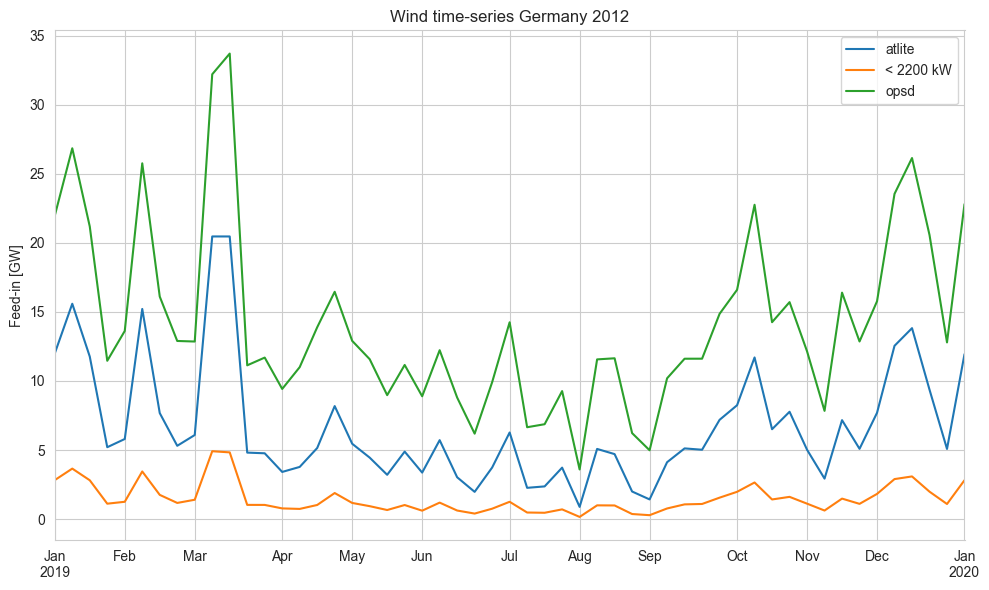

In [110]:
compare.resample("1W").mean().plot(figsize=(10, 6))
plt.ylabel("Feed-in [GW]")
plt.title("Wind time-series Germany 2012")
plt.tight_layout()

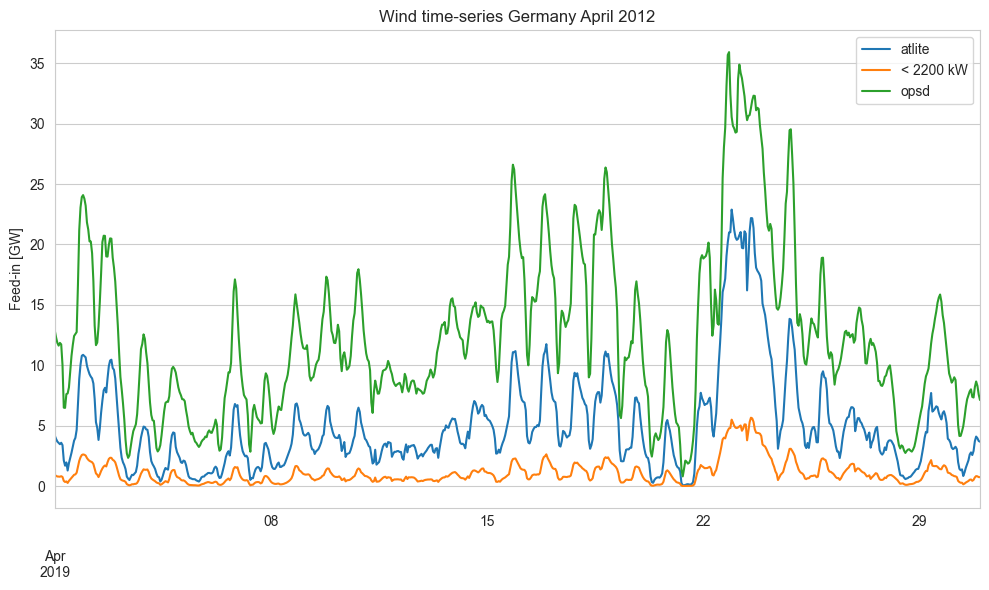

In [111]:
compare.loc["2019-04"].plot(figsize=(10, 6))
plt.ylabel("Feed-in [GW]")
plt.title("Wind time-series Germany April 2012")
plt.tight_layout()

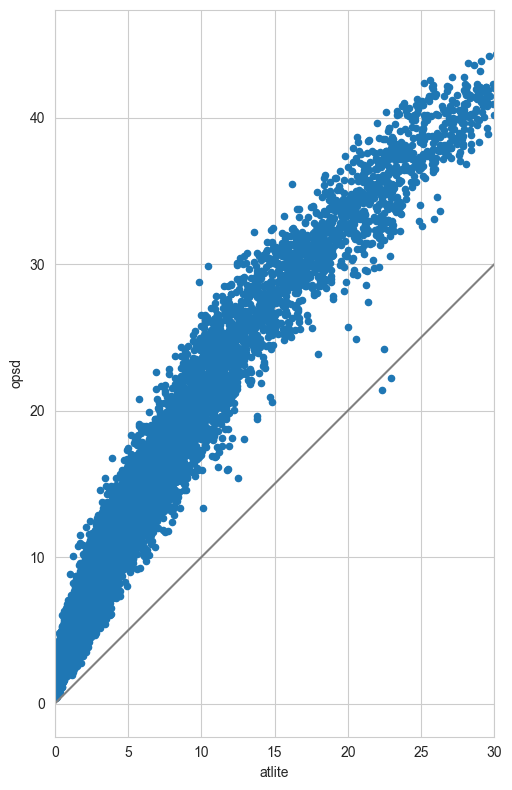

In [112]:
ax = compare.plot(x="atlite", y="opsd", kind="scatter", figsize=(12, 8))
ax.set_aspect("equal")
ax.set_xlim(0, 30)
ax.plot([0, 30], [0, 30], c="gray")
plt.tight_layout()

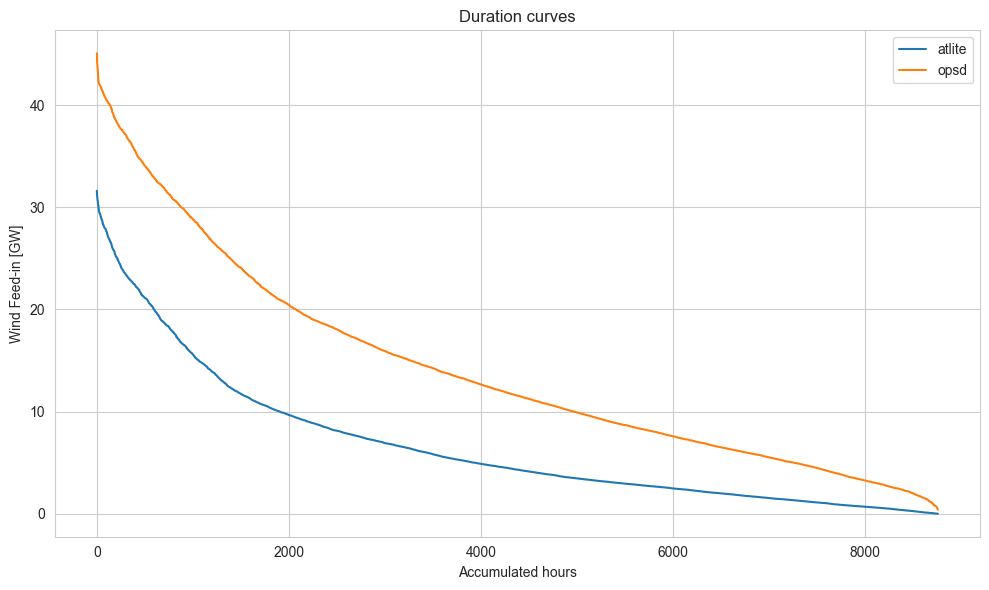

In [113]:
compare["atlite"].sort_values(ascending=False).reset_index(drop=True).plot(
    figsize=(10, 6)
)
compare["opsd"].sort_values(ascending=False).reset_index(drop=True).plot(
    figsize=(10, 6)
)
plt.legend()
plt.title("Duration curves")
plt.ylabel("Wind Feed-in [GW]")
plt.xlabel("Accumulated hours")
plt.tight_layout()

In [114]:
shp = shpreader.Reader(
    shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_1_states_provinces"
    )
)
de_records = list(
    filter(lambda r: r.attributes["iso_3166_2"].startswith("DE"), shp.records())
)
laender = (
    gpd.GeoDataFrame([{**r.attributes, "geometry": r.geometry} for r in de_records])
    .rename(columns={"iso_3166_2": "state"})
    .set_index("state")
    .set_crs(4236)
)

/Users/tomkaehler/Documents/Uni/BA/venv/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


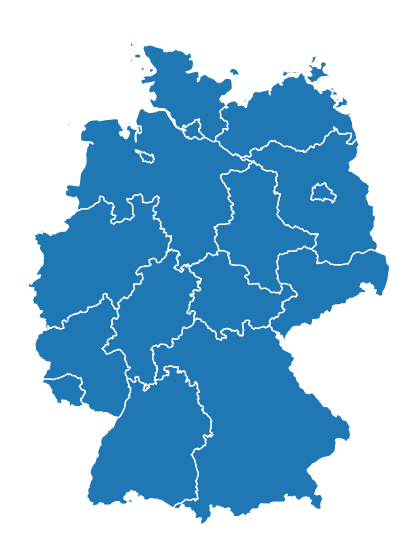

In [115]:
laender.to_crs(3035).plot(figsize=(7, 7))
plt.grid(False)
plt.axis("off");

In [121]:
wind = cutout.wind(
    turbine="Vestas_V90_3MW",
    shapes=laender,
                   )

/Users/tomkaehler/Documents/Uni/BA/venv/lib/python3.11/site-packages/atlite/resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.
  warnings.warn(msg, FutureWarning)


[########################################] | 100% Completed | 21.04 s


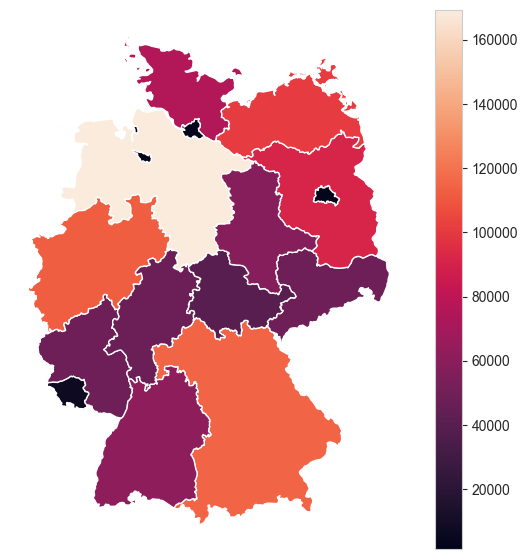

In [122]:
production = wind.sum("time").to_series()
laender.plot(column=production, figsize=(7, 7), legend=True)
plt.grid(False)
plt.axis("off");

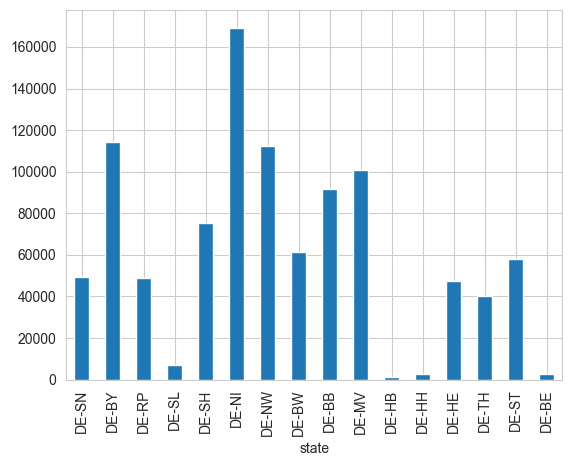

In [123]:
production.plot(kind="bar");

EPSG:3035
[4031323.23344179 2684090.58745545 4671563.2334809  3549826.48824816]
      id NUTS_ID  LEVL_CODE CNTR_CODE   NAME_LATN  NUTS_NAME  MOUNT_TYPE  \
0  BG423   BG423          3        BG  Pazardzhik  Пазарджик         3.0   
1  BG424   BG424          3        BG     Smolyan     Смолян         3.0   
2  BG425   BG425          3        BG   Kardzhali   Кърджали         3.0   

   URBN_TYPE  COAST_TYPE    FID  \
0          2           3  BG423   
1          3           3  BG424   
2          3           3  BG425   

                                            geometry  
0  POLYGON ((24.42101 42.55306, 24.41032 42.46950...  
1  POLYGON ((25.07422 41.79348, 25.05851 41.75177...  
2  POLYGON ((25.94863 41.32034, 25.90644 41.30757...  
id
BG423    POLYGON ((24.42101 42.55306, 24.41032 42.46950...
BG424    POLYGON ((25.07422 41.79348, 25.05851 41.75177...
BG425    POLYGON ((25.94863 41.32034, 25.90644 41.30757...
CH011    MULTIPOLYGON (((6.86623 46.90929, 6.89621 46.9...
CH012    POLYGO

/Users/tomkaehler/Documents/Uni/BA/Wind_power.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Original CRS: None
Successfully combined into a MultiLineString.


/Users/tomkaehler/Documents/Uni/BA/Wind_power.py:102: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


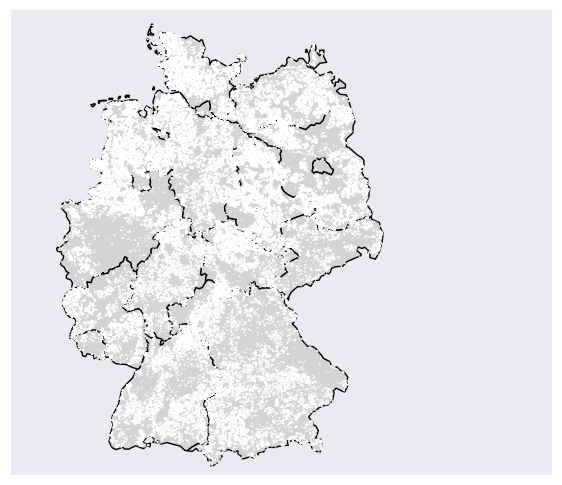

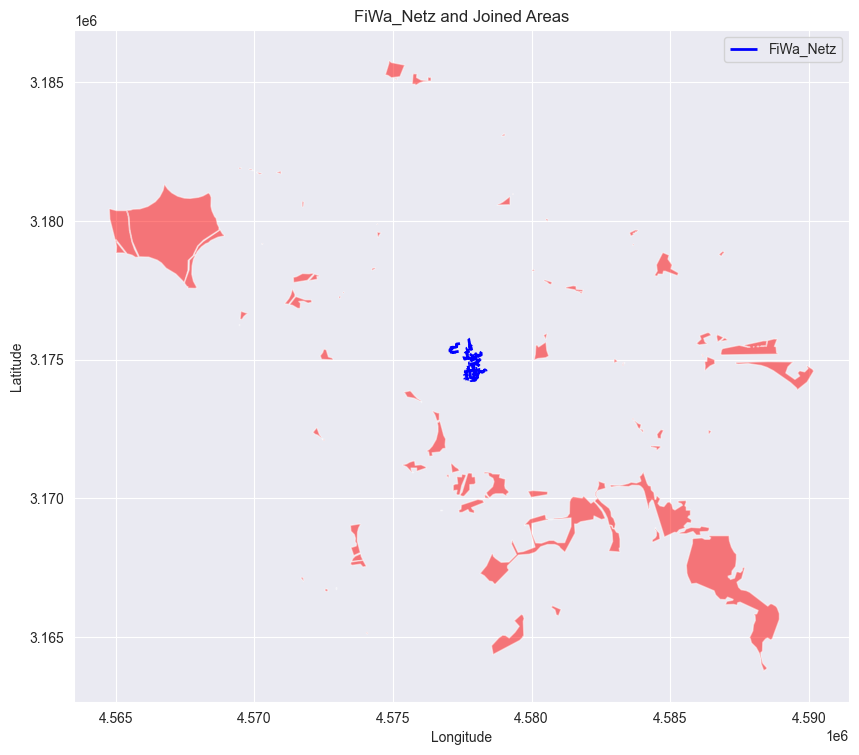

Compute availability matrix: 100%|██████████| 113/113 [00:02<00:00, 44.88 gridcells/s]
/Users/tomkaehler/Documents/Uni/BA/venv/lib/python3.11/site-packages/atlite/resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.
  warnings.warn(msg, FutureWarning)


[########################################] | 100% Completed | 27.62 s


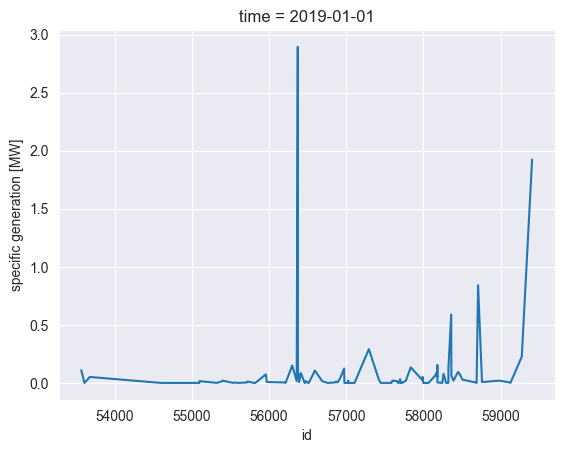

<xarray.DataArray 'specific generation' (time: 8760, id: 113)>
array([[0.11039065, 0.        , 0.0512528 , ..., 0.        , 0.22522839,
        1.92431978],
       [0.12616821, 0.        , 0.0585781 , ..., 0.        , 0.24550205,
        2.09753503],
       [0.15235568, 0.        , 0.07073656, ..., 0.        , 0.29953528,
        2.55918743],
       ...,
       [0.08378166, 0.        , 0.03889863, ..., 0.        , 0.17244088,
        1.47331071],
       [0.05090837, 0.        , 0.02363603, ..., 0.        , 0.11616802,
        0.99252325],
       [0.0565308 , 0.        , 0.02624644, ..., 0.        , 0.13968346,
        1.19343589]])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 ... 2019-12-31T23:00:00
  * id       (id) int64 53566 53609 53678 54602 ... 59123 59127 59274 59408
Attributes:
    units:    MW